In [43]:
%pip install nltk

import numpy as np
import json
import re

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

np.random.seed(1)


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package wordnet to /Users/hstack/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/hstack/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hstack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read in text data for training

In [52]:
# Read one JSON record per line
def read_jsonl(f):
  f = open(f)
  res = []
  for line in f:
    res.append(json.loads(line))
  f.close()
  return res

data = read_jsonl('dev.json') + read_jsonl('test.json') + read_jsonl('train.json')
data = [line['text'] for line in data]
doc_count = len(data)
doc_count

2000

## Clean data

In [53]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    tokens = pattern.findall(text)
    lemmatized_tokens = []
    for token in tokens:
      lemmatized_token = wordnet_lemmatizer.lemmatize(token)
      if lemmatized_token not in stop_words:
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

tokens_by_doc = [tokenize(doc) for doc in data[:50]]

In [54]:
tokens_by_doc[0]

['circumstance',
 'would',
 'discussing',
 'ending',
 'film',
 'extent',
 'particular',
 'review',
 'however',
 'order',
 'fully',
 'explain',
 'exactly',
 'movie',
 'awful',
 'minute',
 'dissection',
 'ending',
 'necessary',
 'even',
 'though',
 'reveal',
 'detail',
 'last',
 'scene',
 'proceed',
 'risk',
 'movie',
 'open',
 'quite',
 'poorly',
 'might',
 'add',
 'child',
 'psychologist',
 'malcolm',
 'crowe',
 'bruce',
 'willis',
 'looking',
 'like',
 'wa',
 'dragged',
 'trailer',
 'wee',
 'hour',
 'morning',
 'shoot',
 'scene',
 'wife',
 'intruded',
 'upon',
 'one',
 "malcolm's",
 'past',
 'patient',
 'distraught',
 'suicidal',
 'man',
 'cameo',
 'new',
 'kid',
 'block',
 'donnie',
 'wahlberg',
 'shoot',
 'malcolm',
 'turn',
 'gun',
 'cut',
 'next',
 'fall',
 'find',
 'good',
 'doctor',
 'quietly',
 'observing',
 'latest',
 'case',
 'trouble',
 'young',
 'man',
 'named',
 'cole',
 'haley',
 'joel',
 'osment',
 'one',
 'child',
 'actor',
 'want',
 'bludgeoned',
 'head',
 'blunt',
 'i

In [55]:
# want to treat the tokens as one long list, rather than a list of tokens per document
# to do this, will insert a special character in between each document to stop the training there
# TLDR insert a stop token between each document to avoid using next/prev document as context
SPECIAL_STOP_TOKEN = '*!!!*'

def combine_tokens():
  ret = []
  for token_list in tokens_by_doc:
    ret.extend(token_list)
    ret.append(SPECIAL_STOP_TOKEN)

  return ret

tokens_with_stops = combine_tokens()

print(len(tokens_with_stops))
# should equal number of documents (2000)
len([token for token in tokens_with_stops if token == SPECIAL_STOP_TOKEN])

16622


50

## Create vocabulary maps

In [57]:
token_to_id = {}
id_to_token = {}

def make_vocabulary(tokens):
  for token in tokens:
    if token not in token_to_id:
      id_no = len(token_to_id) + 1
      token_to_id[token] = id_no
      id_to_token[id_no] = token

for doc in tokens_by_doc:
  make_vocabulary(doc)

print(len(token_to_id))

5344


## Create dataset

In [58]:
def create_one_hot(token_id):
  vector = np.zeros(len(token_to_id) + 1)
  vector[token_id] = 1
  return vector

def yield_range(*ranges):
  for iterable in ranges:
    yield from iterable

def create_dataset(window_size=2):
  X = []
  y = []
  
  # note that this includes stop tokens, which will need to be skipped
  token_count = len(tokens_with_stops)
  print(token_count)

  for i in range(token_count):
    if tokens_with_stops[i] == SPECIAL_STOP_TOKEN:
      continue

    indexes = yield_range(range(max(0, i - window_size), i), range(i, min(token_count, i + window_size + 1)))
    for j in indexes:
      if j == i:
        continue
      
      if tokens_with_stops[j] == SPECIAL_STOP_TOKEN:
        break

      X.append(create_one_hot(token_to_id[tokens_with_stops[i]]))
      y.append(create_one_hot(token_to_id[tokens_with_stops[j]]))

  return np.asarray(X), np.asarray(y)

X, y = create_dataset()

16622


In [59]:
X.shape, y.shape

((65792, 5345), (65792, 5345))

## Create and Initialize Network

In [60]:
def init_network(vocab_size: int, n_embeddings: int) -> dict:
  model = {
    'w1': np.random.randn(vocab_size + 1, n_embeddings),
    'w2': np.random.randn(n_embeddings, vocab_size + 1),
  }
  return model

### Forward Propagation and Helper Functions

In [61]:
def softmax(outputs):
  res = []
  for x in outputs:
    res.append(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())
  return res

def safe_log(array):
  for i in range(len(array)):
    for x in range(len(array[i])):
      if array[i][x] > 0:
        array[i][x] = np.log(array[i][x])
      # else:
      #   array[i][x] = 0
  return array

def cross_entropy_loss(z, y):
  # print(y)
  # print(z)
  # return - np.sum(y * np.log(z))
  print(- np.sum(y * safe_log(z)))
  return - np.sum(y * safe_log(z))

def forward_prop(model, X):
  cache = {}
  cache['a1'] = X @ model['w1']
  cache['a2'] = cache['a1'] @ model['w2']
  cache['z'] = softmax(cache['a2'])
  return cache

def back_prop(model, X, y, alpha):
  cache = forward_prop(model, X)
  da2 = cache['z'] - y
  dw2 = cache['a1'].T @ da2
  da1 = da2 @ model['w2'].T
  dw1 = X.T @ da1
  model['w1'] -= alpha * dw1
  model['w2'] -= alpha * dw2
  return cross_entropy_loss(cache['z'], y)

In [19]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set()

n_iter = 50
learning_rate = 0.05

model = init_network(len(token_to_id), 10)
model['w1'].shape, model['w2'].shape

for i in tqdm(range(n_iter)):
  back_prop(model, X, y, learning_rate)

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


In [11]:
def get_embedding(model, word):
  try:
    idx = token_to_id[word]
  except KeyError:
    print(f'{word} not in corpus')
  one_hot = create_one_hot(idx)
  return forward_prop(model, one_hot)['a1']

In [21]:
get_embedding(model, 'film')

array([-2.40688602e+55, -1.10557696e+55,  4.75933117e+55,  1.59856214e+55,
        8.85353780e+54, -1.32013601e+55, -1.24125605e+55,  3.68753596e+55,
        2.66791727e+55,  2.13621542e+55])

873600.7518369922
866635.8409978411
860705.7516295185
855395.652156907
850541.3736201854
846048.7917058279
841854.4278234957
837912.0977395234
834186.694714012
830650.7129658915


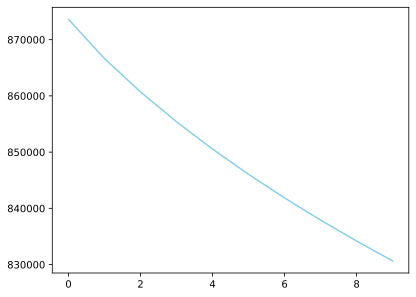

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

n_iter = 10
learning_rate = 0.0001

model = init_network(len(token_to_id), 10)
history = [back_prop(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()